## 데이터 불러오기

In [1]:
#데이터 불러오기


import json
import pandas as pd
import pickle
from tqdm import tqdm
from bson import json_util
from pymongo import MongoClient
from sklearn.feature_extraction.text import TfidfVectorizer 
import operator
from sklearn.metrics.pairwise import cosine_similarity




In [ ]:
# Load All Documents from Selected Collection
conn = MongoClient('13.125.179.232',27017)
db = conn['majormap']
collection = db['majors']
documents = collection.find({},{
    'univname': 1,
    'name': 1,
    'college': 1,
    
    'text_intr': 1,
    'text_lect': 1
})


# Dump MongoDB Document
with open('majors.json', 'w') as f:
    json.dump(json_util.dumps(documents, ensure_ascii=False), f)

# Load MongoDB Document
with open('majors.json', 'r') as f:
    documents = json.loads(json_util.loads(f.read()))

print("Print Sample Data: {}".format(documents[1]))

데이터 300개만 가져와서 

text_name : 대학교명 + 학과명 

text_both : 학과소개글 + 학과에서 배우는 과목소개글

로 정리한 후 text_both를 Tfidf 벡터화하기

In [2]:
documents=pd.read_excel('majors_textSet_복구.xlsx')

In [9]:
#데이터 300개만 빼오기

#데이터를 전부쓰고 싶거나 개수를 수정하고 싶으면 아래 코드중 300을 수정할 것.
# 전부쓰고 싶으면 300을 len(documents) 로 변경
documents=documents[0:300]




In [10]:
#text이름만 따로 저장
text_name=[]                     
for i in range(300):            
    text_name.append(documents['univname'][i]+' '+documents['name'][i])

    
#text introduction이랑 lecture 합쳐서 따로 저장 
text_both=[]
for i in range(300):
    text_both.append(documents['text_intr'][i]+' '+documents['text_lect'][i])
    





In [12]:
#text_both의 벡터화
vectorizer = TfidfVectorizer()


In [13]:
X_both = vectorizer.fit_transform(text_both)

In [16]:
print(X_both[0])

  (0, 82639)	0.003371238327493996
  (0, 80926)	0.006490766791062426
  (0, 82545)	0.005742664975684588
  (0, 17799)	0.00605315528234497
  (0, 51674)	0.004390579477461221
  (0, 34700)	0.006490766791062426
  (0, 10270)	0.006490766791062426
  (0, 7984)	0.006490766791062426
  (0, 9403)	0.004650861532362207
  (0, 8303)	0.005742664975684588
  (0, 32802)	0.004994563160306748
  (0, 115652)	0.002036421722145976
  (0, 84631)	0.006490766791062426
  (0, 88967)	0.0034329284192335893
  (0, 100191)	0.005742664975684588
  (0, 90962)	0.005501829983478223
  (0, 84626)	0.006490766791062426
  (0, 50233)	0.0053050534669671304
  (0, 45198)	0.004181030234611428
  (0, 67783)	0.004867441958249673
  (0, 84618)	0.005501829983478223
  (0, 18620)	0.0024188908808189928
  (0, 84623)	0.006490766791062426
  (0, 84625)	0.006490766791062426
  (0, 84627)	0.006490766791062426
  :	:
  (0, 47134)	0.006490766791062426
  (0, 78113)	0.002953800916041681
  (0, 110674)	0.004119340142871834
  (0, 84801)	0.02165748811330415
  (0, 1

In [17]:

X_both = X_both.todense()


In [19]:
X_both[0]

matrix([[0., 0., 0., ..., 0., 0., 0.]])

## 300개 서로 유사도 계산 후 가장 유사한 학과 5개 선정하기

In [59]:
#300개를 서로 유사도 계산하기 (같은 대학 포함)
result={}
for j in range(300):
    temparr=[]                   
    major2simil={}                
    for i in range(300):       #j와 j를 포함한 모든 학과들과의 유사도 계산 후 temparr에 저장
        temp=cosine_similarity(X_both[j],X_both[i])    #temp : j와 i 학과의 유사도 임시저장
        temparr.append(temp)
        
        major2simil[text_name[i]]=(str(temp))[2:-2]     #학교명:유사도를 딕셔너리에 삽입
            
        tt=sorted(major2simil.items(),key=operator.itemgetter(1),reverse=True)     #유사도가 가장 높은 순으로 정열        

    # j와 유사도가 가장높은 5개를 추출
    top5=[]
    for q in range(1,6):         #1부터 시작하는 이유는 0번째, 즉 유사도가 제일 높은 것이 자기 자신이기 떄문에
        top5.append(tt[q][0])
    print(text_name[j],'와 유사한 학과는\n', top5,'입니다.')
    result[text_name[j]]=top5

동국대학교 법학과 와 유사한 학과는
 ['동국대학교 교육학과', '동국대학교 경영학과', '동국대학교 국어국문문예창작학부', '동국대학교 경제학과', '동국대학교 회계학과'] 입니다.
동국대학교 국어국문문예창작학부 와 유사한 학과는
 ['동국대학교 국어교육과', '동국대학교 영어영문학부', '동국대학교 교육학과', '동국대학교 사학과', '동국대학교 경영학과'] 입니다.
동국대학교 영어영문학부 와 유사한 학과는
 ['동국대학교 국어국문문예창작학부', '동국대학교 경영학과', '동국대학교 교육학과', '동국대학교 국어교육과', '동국대학교 미디어커뮤니케이션학전공'] 입니다.
동국대학교 일본학과 와 유사한 학과는
 ['삼육대학교 일본어학과', '동국대학교 국어국문문예창작학부', '동국대학교 국어교육과', '국민대학교 일본학과', '동국대학교 영어영문학부'] 입니다.
동국대학교 중어중문학과 와 유사한 학과는
 ['삼육대학교 중국어학과', '국민대학교 중국어문전공', '동국대학교 국어국문문예창작학부', '강남대학교 글로벌학부', '동국대학교 국어교육과'] 입니다.
동국대학교 철학과 와 유사한 학과는
 ['동국대학교 사학과', '동국대학교 국어국문문예창작학부', '동국대학교 교육학과', '동국대학교 불교학부', '동국대학교 법학과'] 입니다.
동국대학교 사학과 와 유사한 학과는
 ['동국대학교 국어국문문예창작학부', '동국대학교 철학과', '동국대학교 역사교육과', '동국대학교 교육학과', '동국대학교 불교학부'] 입니다.
동국대학교 교육학과 와 유사한 학과는
 ['동국대학교 국어교육과', '동국대학교 국어국문문예창작학부', '동국대학교 경영학과', '동국대학교 수학교육과', '동국대학교 가정교육과'] 입니다.
동국대학교 국어교육과 와 유사한 학과는
 ['동국대학교 국어국문문예창작학부', '동국대학교 교육학과', '동국대학교 영어영문학부', '동국대학교 수학교육과', '동국대학교 사학과'] 입니다.
동국대학교 역사교육과 와 유사한 학과는
 ['동국대학교 사학과', '동

 ['강남대학교 사회복지학부', '삼육대학교 사회복지학과', '동덕여자대학교 아동학과', '동덕여자대학교 문헌정보학과', '동덕여자대학교 컴퓨터학과'] 입니다.
동덕여자대학교 아동학과 와 유사한 학과는
 ['삼육대학교 유아교육과', '동덕여자대학교 사회복지학과', '강남대학교 유아교육과', '삼육대학교 상담심리학과', '동덕여자대학교 문헌정보학과'] 입니다.
동덕여자대학교 회화과 와 유사한 학과는
 ['동덕여자대학교 큐레이터학과', '동덕여자대학교 디지털공예과', '강남대학교 미술문화복지전공', '동국대학교 미술학부', '국민대학교 회화전공'] 입니다.
동덕여자대학교 디지털공예과 와 유사한 학과는
 ['국민대학교 금속공예학과', '동덕여자대학교 회화과', '동덕여자대학교 미디어디자인학과', '국민대학교 도자공예학과', '동덕여자대학교 시각/실내디자인학과'] 입니다.
동덕여자대학교 큐레이터학과 와 유사한 학과는
 ['동덕여자대학교 회화과', '강남대학교 미술문화복지전공', '국민대학교 입체미술전공', '동덕여자대학교 사회복지학과', '동덕여자대학교 모델과'] 입니다.
동덕여자대학교 피아노과 와 유사한 학과는
 ['동덕여자대학교 성악과', '동덕여자대학교 관현악과', '강남대학교 음악학과', '동덕여자대학교 실용음악과', '국민대학교 피아노전공'] 입니다.
동덕여자대학교 관현악과 와 유사한 학과는
 ['동덕여자대학교 성악과', '동덕여자대학교 피아노과', '동덕여자대학교 실용음악과', '강남대학교 음악학과', '국민대학교 피아노전공'] 입니다.
동덕여자대학교 성악과 와 유사한 학과는
 ['강남대학교 음악학과', '동덕여자대학교 관현악과', '동덕여자대학교 피아노과', '동덕여자대학교 실용음악과', '국민대학교 성악전공'] 입니다.
동덕여자대학교 패션디자인학과 와 유사한 학과는
 ['국민대학교 의상디자인학과', '동덕여자대학교 경제학과', '동덕여자대학교 모델과', '동덕여자대학교 미디어디자인학과', '동덕여자대학교 경영학과'] 입니다.
동덕여자대학교 시각/실내디자

 ['국민대학교 식품영양학과', '동덕여자대학교 식품영양학과', '동국대학교 식품생명공학과', '동국대학교 식품산업관리학과', '서울여자대학교 식품응용시스템학부'] 입니다.
삼육대학교 생활체육학과 와 유사한 학과는
 ['동국대학교 스포츠문화학과', '국민대학교 스포츠교육학과', '광운대학교 스포츠융합과학과', '강남대학교 스포츠복지전공', '동덕여자대학교 체육학과'] 입니다.
삼육대학교 약학과 와 유사한 학과는
 ['동덕여자대학교 약학과', '삼육대학교 화학생명과학과', '동덕여자대학교 응용화학전공', '국민대학교 바이오발효융합학과', '삼육대학교 보건관리학과'] 입니다.
삼육대학교 건축학과(5년제) 와 유사한 학과는
 ['국민대학교 건축학부', '광운대학교 건축학과', '광운대학교 건축공학과', '동국대학교 건축공학부', '국민대학교 공업디자인학과'] 입니다.
삼육대학교 아트앤디자인학과 와 유사한 학과는
 ['동덕여자대학교 미디어디자인학과', '국민대학교 공업디자인학과', '강남대학교 유니버설비주얼디자인전공', '국민대학교 시각디자인학과', '동덕여자대학교 시각/실내디자인학과'] 입니다.
삼육대학교 중국어학과 와 유사한 학과는
 ['국민대학교 중국어문전공', '동국대학교 중어중문학과', '동덕여자대학교 중어중국학과', '강남대학교 글로벌학부', '국민대학교 중국정경전공'] 입니다.
삼육대학교 일본어학과 와 유사한 학과는
 ['동덕여자대학교 일본어과', '동국대학교 일본학과', '국민대학교 일본학과', '고려대학교 일어일문학과', '서울여자대학교 일어일문학과'] 입니다.
삼육대학교 경영학과 와 유사한 학과는
 ['서강대학교 경제학전공', '국민대학교 경영학부', '강남대학교 글로벌경영학부', '서강대학교 경영학전공', '삼육대학교 경영정보학과'] 입니다.
삼육대학교 경영정보학과 와 유사한 학과는
 ['국민대학교 경영정보학부', '광운대학교 경영학부', '국민대학교 경영학부', '강남대학교 글로벌경영학부', '국민대학교 빅데이터경영통계전공'] 입니다.
삼육대학교

## 300개 서로 유사도 계산 후 가장 유사한 학과 5개 선정하기 ( 같은 대학교 X)

In [60]:
#(같은 대학 불포함)
# 아이디어 : 학교명이 같으면 major2simil이란 딕셔너리에 추가하지 않는다.
result={}
for j in range(300):
    temparr=[]                   
    major2simil={}                
    for i in range(300):       #j와 j를 포함한 모든 학과들과의 유사도 계산 후 temparr에 저장
        temp=cosine_similarity(X_both[j],X_both[i]) 
        temparr.append(temp)
        
        if text_name[i].split()[0] == text_name[j].split()[0]: #같은 학교명이라면 pass
            pass
        
        else:                                   #학교명이 다르면 학교명:유사도를 딕셔너리에 추가
            major2simil[text_name[i]]=(str(temp))[2:-2]
            
        sorted_major2simil=sorted(major2simil.items(),key=operator.itemgetter(1),reverse=True)     #유사도가 가장 높은 순으로 정열        

    # j와 유사도가 가장높은 5개를 추출
    top5=[]
        
    for q in range(1,6):         #1부터 시작하는 이유는 0번째, 즉 유사도가 제일 높은 것이 자기 자신이기 떄문에
        top5.append(sorted_major2simil[q][0])
    print(text_name[j],'와 유사한 학과는\n', top5,'입니다.')
    result[text_name[j]]=top5

동국대학교 법학과 와 유사한 학과는
 ['광운대학교 법학부', '국민대학교 영어영문학부', '강남대학교 공공인재학과', '국민대학교 국제통상학과', '국민대학교 한국역사학과'] 입니다.
동국대학교 국어국문문예창작학부 와 유사한 학과는
 ['국민대학교 국어국문학전공', '국민대학교 한국역사학과', '국민대학교 글로벌한국어전공', '광운대학교 국어국문학과', '강남대학교 한영문화콘텐츠학과'] 입니다.
동국대학교 영어영문학부 와 유사한 학과는
 ['동덕여자대학교 영어과', '광운대학교 영어영문학과', '강남대학교 한영문화콘텐츠학과', '국민대학교 국제통상학과', '강남대학교 글로벌학부'] 입니다.
동국대학교 일본학과 와 유사한 학과는
 ['국민대학교 일본학과', '동덕여자대학교 일본어과', '국민대학교 영어영문학부', '광운대학교 동북아문화산업학부', '광운대학교 국제학부'] 입니다.
동국대학교 중어중문학과 와 유사한 학과는
 ['국민대학교 중국어문전공', '강남대학교 글로벌학부', '동덕여자대학교 중어중국학과', '국민대학교 중국정경전공', '국민대학교 영어영문학부'] 입니다.
동국대학교 철학과 와 유사한 학과는
 ['국민대학교 한국역사학과', '강남대학교 기독교학과', '국민대학교 국제통상학과', '광운대학교 국제학부', '국민대학교 법학부'] 입니다.
동국대학교 사학과 와 유사한 학과는
 ['국민대학교 영어영문학부', '광운대학교 국제학부', '강남대학교 기독교학과', '강남대학교 글로벌학부', '동덕여자대학교 국사학과'] 입니다.
동국대학교 교육학과 와 유사한 학과는
 ['국민대학교 교육학과', '강남대학교 교육학과', '강남대학교 초등특수교육과', '강남대학교 중등특수교육과', '국민대학교 한국역사학과'] 입니다.
동국대학교 국어교육과 와 유사한 학과는
 ['국민대학교 국어국문학전공', '국민대학교 글로벌한국어전공', '국민대학교 한국역사학과', '광운대학교 국어국문학과', '국민대학교 교육학과'] 입니다.
동국대학교 역사교육과 와 유사한 학과는
 ['국민

 ['삼육대학교 사회복지학과', '국민대학교 교육학과', '광운대학교 행정학과', '삼육대학교 보건관리학과', '동국대학교 사회학전공'] 입니다.
동덕여자대학교 아동학과 와 유사한 학과는
 ['강남대학교 유아교육과', '삼육대학교 상담심리학과', '고려대학교 가정교육과', '서강대학교 심리학전공', '국민대학교 교육학과'] 입니다.
동덕여자대학교 회화과 와 유사한 학과는
 ['동국대학교 미술학부', '국민대학교 회화전공', '국민대학교 입체미술전공', '국민대학교 시각디자인학과', '국민대학교 영상디자인학과'] 입니다.
동덕여자대학교 디지털공예과 와 유사한 학과는
 ['국민대학교 도자공예학과', '국민대학교 공업디자인학과', '국민대학교 입체미술전공', '강남대학교 유니버설비주얼디자인전공', '국민대학교 영상디자인학과'] 입니다.
동덕여자대학교 큐레이터학과 와 유사한 학과는
 ['국민대학교 입체미술전공', '국민대학교 회화전공', '국민대학교 금속공예학과', '광운대학교 동북아문화산업학부', '광운대학교 행정학과'] 입니다.
동덕여자대학교 피아노과 와 유사한 학과는
 ['국민대학교 피아노전공', '국민대학교 성악전공', '국민대학교 작곡전공', '국민대학교 관현악전공', '광운대학교 국어국문학과'] 입니다.
동덕여자대학교 관현악과 와 유사한 학과는
 ['국민대학교 피아노전공', '국민대학교 작곡전공', '국민대학교 관현악전공', '국민대학교 성악전공', '국민대학교 국어국문학전공'] 입니다.
동덕여자대학교 성악과 와 유사한 학과는
 ['국민대학교 성악전공', '국민대학교 피아노전공', '국민대학교 작곡전공', '국민대학교 관현악전공', '국민대학교 연극전공'] 입니다.
동덕여자대학교 패션디자인학과 와 유사한 학과는
 ['삼육대학교 아트앤디자인학과', '국민대학교 공업디자인학과', '강남대학교 유니버설비주얼디자인전공', '국민대학교 시각디자인학과', '광운대학교 정보융합학부'] 입니다.
동덕여자대학교 시각/실내디자인학과 와 유사한 학과는
 ['삼육대학교 아트앤디

 ['고려대학교 독어독문학과', '서강대학교 유럽문화전공', '광운대학교 동북아문화산업학부', '강남대학교 글로벌학부', '광운대학교 국어국문학과'] 입니다.
서울여자대학교 중어중문학과 와 유사한 학과는
 ['삼육대학교 중국어학과', '국민대학교 중국어문전공', '고려대학교 중어중문학과', '국민대학교 중국정경전공', '서강대학교 중국문화전공'] 입니다.
서울여자대학교 일어일문학과 와 유사한 학과는
 ['동덕여자대학교 일본어과', '고려대학교 일어일문학과', '국민대학교 일본학과', '광운대학교 동북아문화산업학부', '동국대학교 일본학과'] 입니다.
서울여자대학교 사학과 와 유사한 학과는
 ['동덕여자대학교 중어중국학과', '국민대학교 한국역사학과', '고려대학교 역사교육과', '동덕여자대학교 국사학과', '고려대학교 한국사학과'] 입니다.
서울여자대학교 기독교학과 와 유사한 학과는
 ['삼육대학교 신학과', '동국대학교 사회학전공', '광운대학교 국어국문학과', '광운대학교 미디어커뮤니케이션학부', '국민대학교 미디어전공'] 입니다.
서울여자대학교 수학과 와 유사한 학과는
 ['광운대학교 수학과', '서강대학교 수학전공', '고려대학교 수학과', '국민대학교 정보보안암호수학과', '고려대학교 수학교육과'] 입니다.
서울여자대학교 화학생명환경과학부 와 유사한 학과는
 ['삼육대학교 화학생명과학과', '서강대학교 화학전공', '고려대학교 생명과학부', '동덕여자대학교 화장품학전공', '고려대학교 화학과'] 입니다.
서울여자대학교 원예생명조경학과 와 유사한 학과는
 ['고려대학교 생명공학부', '삼육대학교 동물생명자원학과', '삼육대학교 화학생명과학과', '삼육대학교 컴퓨터공학부', '국민대학교 융합기계공학전공'] 입니다.
서울여자대학교 식품응용시스템학부 와 유사한 학과는
 ['국민대학교 식품영양학과', '삼육대학교 식품영양학과', '고려대학교 식품공학과', '고려대학교 바이오시스템의과학부', '국민대학교 바이오발효융합학과'] 입니다.
서울여자대학교 경제학과 와 

## ㅡㅡㅡㅡㅡㅡ여기서 부턴 Doc2vecㅡㅡㅡㅡㅡㅡㅡㅡㅡ

In [61]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

# 문서들 tag화하기
tagged_text_both = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(text_both)]

In [67]:
# doc3vec 모델 데이터 바탕으로 훈련하기

max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_text_both)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_text_both,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0


C:\Users\jihun\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [68]:
# 결과값 도출 ( 유사도가 가장 높은 5개 뽑기)

from gensim.models.doc2vec import Doc2Vec
model= Doc2Vec.load("d2v.model")

vector_arr=[]
for i in range(300):
    data = word_tokenize(text_both[i].lower())
    v=model.infer_vector(data)
    vector_arr.append(v)
    
for i in range(300):
    print(text_name[i],'와(과) 유사한 학과는 ',text_name[int(model.docvecs.most_similar(i)[0][0])],',',text_name[int(model.docvecs.most_similar(i)[1][0])],',',text_name[int(model.docvecs.most_similar(i)[2][0])],',',text_name[int(model.docvecs.most_similar(i)[3][0])],',',text_name[int(model.docvecs.most_similar(i)[4][0])])

동국대학교 법학과 와(과) 유사한 학과는  동국대학교 경찰행정학부 , 광운대학교 법학부 , 강남대학교 공공인재학과 , 국민대학교 법학부 , 동국대학교 회계학과
동국대학교 국어국문문예창작학부 와(과) 유사한 학과는  동국대학교 국어교육과 , 광운대학교 국어국문학과 , 국민대학교 국어국문학전공 , 동덕여자대학교 문예창작과 , 고려대학교 불어불문학과
동국대학교 영어영문학부 와(과) 유사한 학과는  국민대학교 영어영문학부 , 고려대학교 독어독문학과 , 광운대학교 영어영문학과 , 서강대학교 유럽문화전공 , 고려대학교 영어영문학과
동국대학교 일본학과 와(과) 유사한 학과는  고려대학교 일어일문학과 , 동덕여자대학교 일본어과 , 삼육대학교 일본어학과 , 서울여자대학교 중어중문학과 , 서울여자대학교 일어일문학과
동국대학교 중어중문학과 와(과) 유사한 학과는  삼육대학교 중국어학과 , 동덕여자대학교 프랑스어과 , 국민대학교 중국어문전공 , 동국대학교 일본학과 , 고려대학교 중어중문학과
동국대학교 철학과 와(과) 유사한 학과는  서강대학교 철학전공 , 고려대학교 철학과 , 동국대학교 불교학부 , 동국대학교 국어교육과 , 고려대학교 언어학과
동국대학교 사학과 와(과) 유사한 학과는  동국대학교 역사교육과 , 고려대학교 사학과 , 고려대학교 한국사학과 , 고려대학교 중어중문학과 , 서강대학교 사학전공
동국대학교 교육학과 와(과) 유사한 학과는  국민대학교 교육학과 , 고려대학교 사회학과 , 삼육대학교 상담심리학과 , 고려대학교 간호학과 , 삼육대학교 사회복지학과
동국대학교 국어교육과 와(과) 유사한 학과는  국민대학교 국어국문학전공 , 국민대학교 글로벌한국어전공 , 동국대학교 국어국문문예창작학부 , 고려대학교 국어국문학과 , 고려대학교 불어불문학과
동국대학교 역사교육과 와(과) 유사한 학과는  고려대학교 한국사학과 , 국민대학교 한국역사학과 , 동덕여자대학교 국사학과 , 동국대학교 사학과 , 고려대학교 한문학과
동국대학교 지리교육과 와(과) 유사한 학과는  고려대학교 역사교육과 ,

동덕여자대학교 일본어과 와(과) 유사한 학과는  삼육대학교 일본어학과 , 동국대학교 일본학과 , 국민대학교 일본학과 , 동덕여자대학교 중어중국학과 , 서울여자대학교 일어일문학과
동덕여자대학교 프랑스어과 와(과) 유사한 학과는  삼육대학교 중국어학과 , 동국대학교 중어중문학과 , 동덕여자대학교 독일어과 , 고려대학교 서어서문학과 , 서강대학교 유럽문화전공
동덕여자대학교 독일어과 와(과) 유사한 학과는  동덕여자대학교 영어과 , 삼육대학교 중국어학과 , 고려대학교 독어독문학과 , 서강대학교 중국문화전공 , 동덕여자대학교 프랑스어과
동덕여자대학교 중어중국학과 와(과) 유사한 학과는  국민대학교 중국정경전공 , 강남대학교 글로벌학부 , 광운대학교 국제학부 , 삼육대학교 일본어학과 , 삼육대학교 중국어학과
광운대학교 컴퓨터정보공학부 와(과) 유사한 학과는  광운대학교 전자통신공학과 , 광운대학교 전자공학과 , 광운대학교 전자융합공학과 , 광운대학교 소프트웨어학부 , 삼육대학교 컴퓨터공학부
광운대학교 소프트웨어학부 와(과) 유사한 학과는  동덕여자대학교 컴퓨터학과 , 국민대학교 소프트웨어학부 , 서강대학교 컴퓨터공학전공 , 광운대학교 컴퓨터정보공학부 , 강남대학교 소프트웨어응용학부
광운대학교 정보융합학부 와(과) 유사한 학과는  동국대학교 경영정보학과 , 국민대학교 경영정보학부 , 광운대학교 미디어커뮤니케이션학부 , 동덕여자대학교 컴퓨터학과 , 삼육대학교 경영정보학과
광운대학교 국어국문학과 와(과) 유사한 학과는  국민대학교 국어국문학전공 , 동덕여자대학교 국어국문학과 , 동국대학교 국어국문문예창작학부 , 동덕여자대학교 문예창작과 , 고려대학교 국어국문학과
광운대학교 영어영문학과 와(과) 유사한 학과는  국민대학교 영어영문학부 , 동덕여자대학교 영어과 , 동국대학교 영어영문학부 , 광운대학교 미디어커뮤니케이션학부 , 서강대학교 미국문화전공
광운대학교 미디어커뮤니케이션학부 와(과) 유사한 학과는  국민대학교 미디어전공 , 광운대학교 영어영문학과 , 동국대학교 미디어커뮤니케

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 동국대학교 경제학과 , 고려대학교 국제학부
고려대학교 국제학부 와(과) 유사한 학과는  동국대학교 국제통상학과 , 서울여자대학교 경제학과 , 고려대학교 경제학과 , 국민대학교 국제통상학과 , 동국대학교 경제학과
고려대학교 교육학과 와(과) 유사한 학과는  고려대학교 가정교육과 , 고려대학교 간호학과 , 동국대학교 교육학과 , 국민대학교 교육학과 , 고려대학교 사회학과
고려대학교 체육교육과 와(과) 유사한 학과는  동국대학교 스포츠문화학과 , 동국대학교 체육교육과 , 고려대학교 의예과 , 고려대학교 간호학과 , 고려대학교 교육학과
고려대학교 가정교육과 와(과) 유사한 학과는  서울여자대학교 기독교학과 , 동국대학교 가정교육과 , 서울여자대학교 식품응용시스템학부 , 고려대학교 역사교육과 , 고려대학교 교육학과
고려대학교 수학교육과 와(과) 유사한 학과는  동국대학교 수학교육과 , 서울여자대학교 수학과 , 고려대학교 수학과 , 서강대학교 수학전공 , 동국대학교 수학과
고려대학교 국어교육과 와(과) 유사한 학과는  서울여자대학교 국어국문학과 , 고려대학교 한문학과 , 서울여자대학교 불어불문학과 , 고려대학교 중어중문학과 , 고려대학교 역사교육과
고려대학교 영어교육과 와(과) 유사한 학과는  서울여자대학교 영어영문학과 , 서울여자대학교 불어불문학과 , 서울여자대학교 독어독문학과 , 서울여자대학교 기독교학과 , 고려대학교 불어불문학과
고려대학교 지리교육과 와(과) 유사한 학과는  서울여자대학교 사학과 , 서울여자대학교 일어일문학과 , 고려대학교 역사교육과 , 서울여자대학교 중어중문학과 , 서울여자대학교 원예생명조경학과
고려대학교 역사교육과 와(과) 유사한 학과는  서울여자대학교 사학과 , 고려대학교 지리교육과 , 서울여자대학교 기독교학과 , 서울여자대학교 국어국문학과 , 고려대학교 가정교육과
고려대학교 수학과 와(과) 유사한 학과는  서울여자대학교 수학과 , 고려대학교 수학교육과 , 동국대학교 수학과 , 고려대학교 물리학과 , 고려대학교 지구환경과학과
고려대학교 물리학

## TF-IDF바탕으로 시각화하기(PCA이용)

In [21]:


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

text_vec = vectorizer.fit_transform(text_both)
text_vec=text_vec.todense()
text_standard = StandardScaler().fit_transform(X_both)



In [22]:
text_standard

array([[-0.08419364, -0.05783149, -0.05783149, ..., -0.05783149,
        -0.05783149, -0.05783149],
       [-0.08419364, -0.05783149, -0.05783149, ..., -0.05783149,
        -0.05783149, -0.05783149],
       [-0.08419364, -0.05783149, -0.05783149, ..., -0.05783149,
        -0.05783149, -0.05783149],
       ...,
       [-0.08419364, -0.05783149, -0.05783149, ..., -0.05783149,
        -0.05783149, -0.05783149],
       [-0.08419364, -0.05783149, -0.05783149, ..., -0.05783149,
        -0.05783149, -0.05783149],
       [-0.08419364, -0.05783149, -0.05783149, ..., -0.05783149,
        -0.05783149, -0.05783149]])

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(text_standard)



df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'],index=text_name)

<function matplotlib.pyplot.show(*args, **kw)>

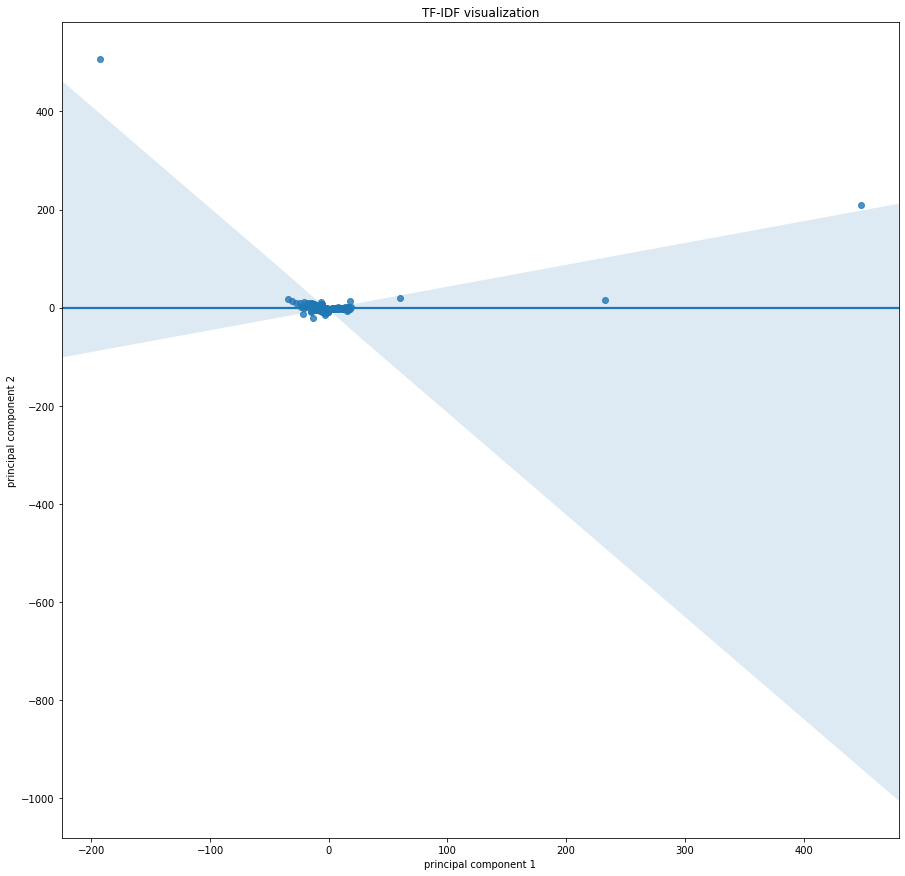

In [200]:
plt.figure(figsize=(15, 15))
sns.regplot(x='principal component 1',y='principal component 2',data=df)

plt.title("TF-IDF visualization")
plt.show

### 큰값 3개 삭제 후

In [201]:
ind= df[df['principal component 1']>100].index
df_new=df.drop(ind)
ind= df_new[df_new['principal component 2']>100].index
df__new=df_new.drop(ind)
df__new
df=df__new

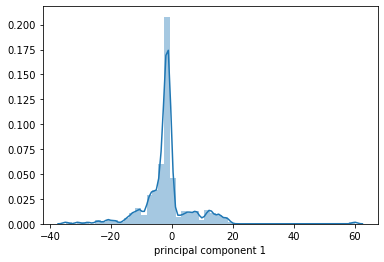

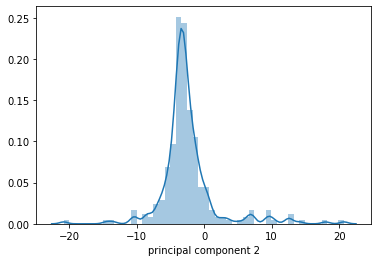

In [202]:
sns.distplot(df['principal component 1'])
plt.show()
sns.distplot(df['principal component 2'])
plt.show()

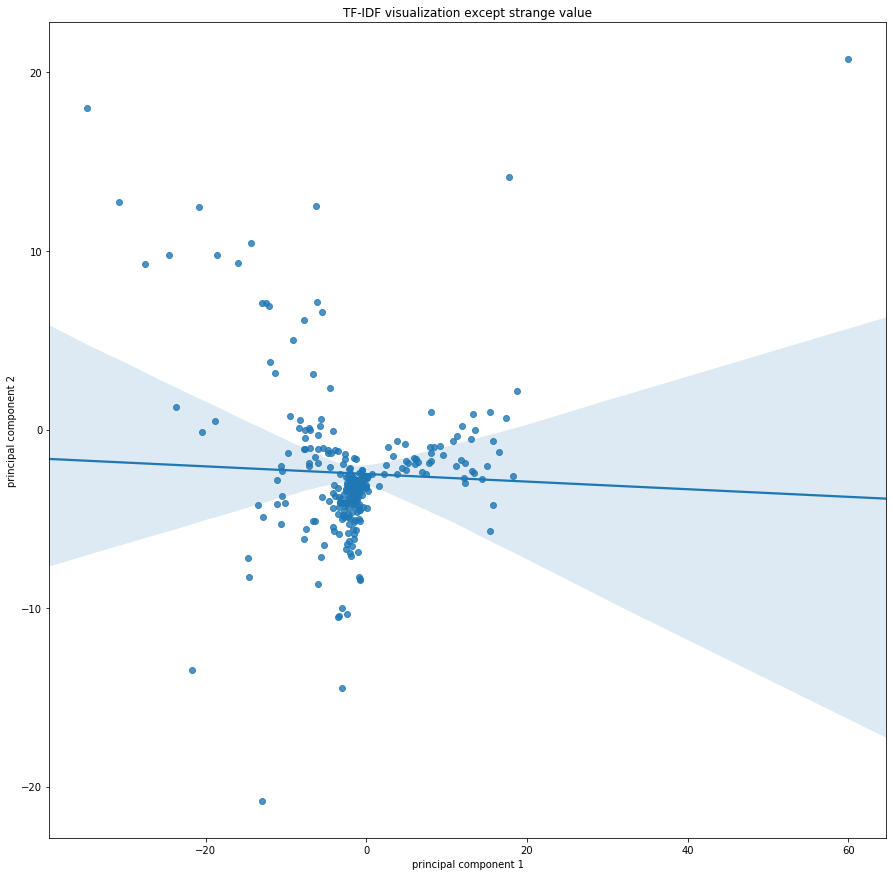

<Figure size 1080x1080 with 0 Axes>

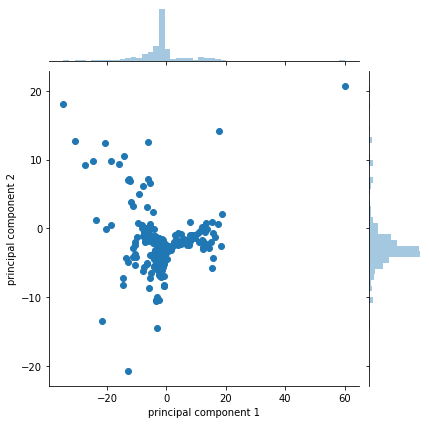

In [206]:


plt.figure(figsize=(15, 15))
sns.regplot(x='principal component 1',y='principal component 2',data=df ) 
plt.title('TF-IDF visualization except strange value')
plt.show()

plt.figure(figsize=(15, 15))
sns.jointplot(x='principal component 1',y='principal component 2',data=df ) 
plt.show()

## Doc2vec 벡터를 이용한 시각화

In [207]:

text_standard = StandardScaler().fit_transform(vector_arr)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(text_standard)



df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'],index=text_name)

In [243]:
index_arr=[]
for i in range(len(df)):
    index_arr.append(df.index(i))

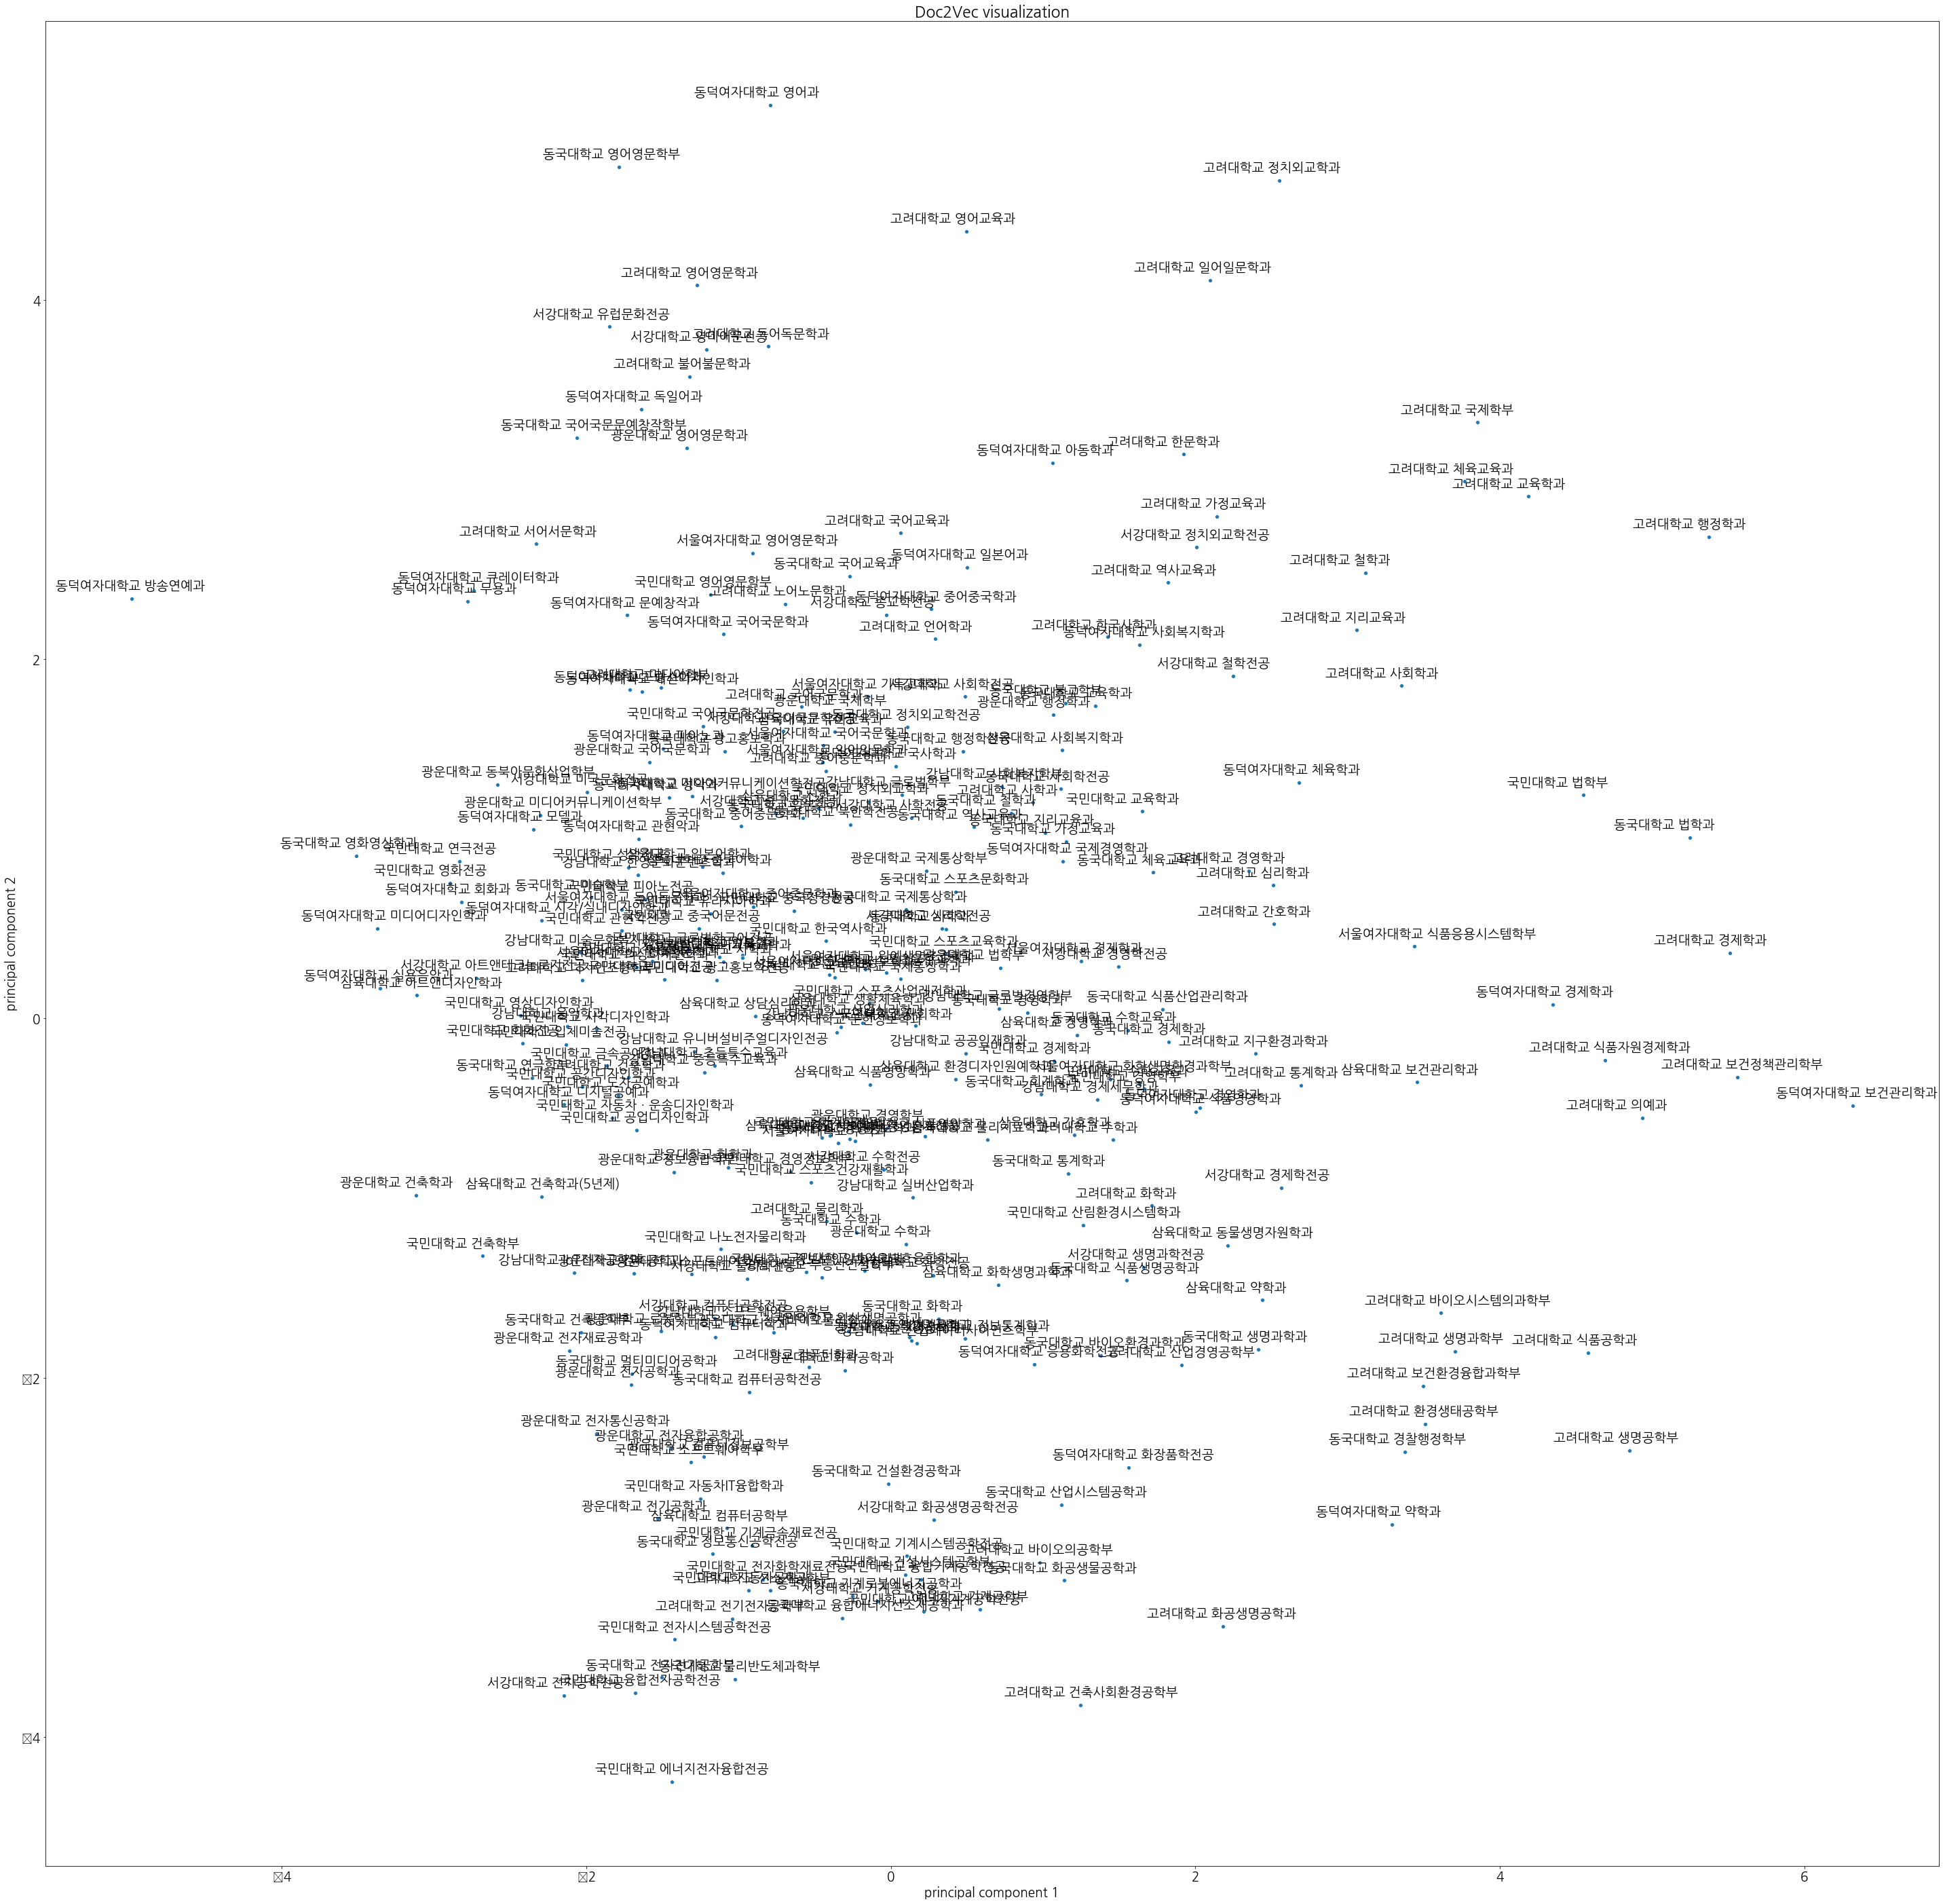

In [259]:

plt.figure(figsize=(50, 50))
ax=sns.scatterplot(x='principal component 1',y='principal component 2',data=df ) 
plt.title('Doc2Vec visualization')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 19
for i in range(len(df)):
    ax.text(float(df['principal component 1'][i]) - 0.5, float(df['principal component 2'][i]) + 0.05, df.index[i])

## 글자를 알아보기 힘들어 4등분하여 표시

In [302]:

df_1=pd.DataFrame(columns=['principal component 1','principal component 2'])
df_2=pd.DataFrame(columns=['principal component 1','principal component 2'])
df_3=pd.DataFrame(columns=['principal component 1','principal component 2'])
df_4=pd.DataFrame(columns=['principal component 1','principal component 2'])



for i in range (len(df)):
    if df['principal component 1'][i]>0 and df['principal component 2'][i]>0:
        df_1.loc[df.index[i]]=[df['principal component 1'][i],df['principal component 2'][i]]    
    elif df['principal component 1'][i]<0 and df['principal component 2'][i]>0:
        df_2.loc[df.index[i]]=[df['principal component 1'][i],df['principal component 2'][i]]    
    elif df['principal component 1'][i]<0 and df['principal component 2'][i]<0:
        df_3.loc[df.index[i]]=[df['principal component 1'][i],df['principal component 2'][i]]    
    else: 
        df_4.loc[df.index[i]]=[df['principal component 1'][i],df['principal component 2'][i]]    


### 1사분면

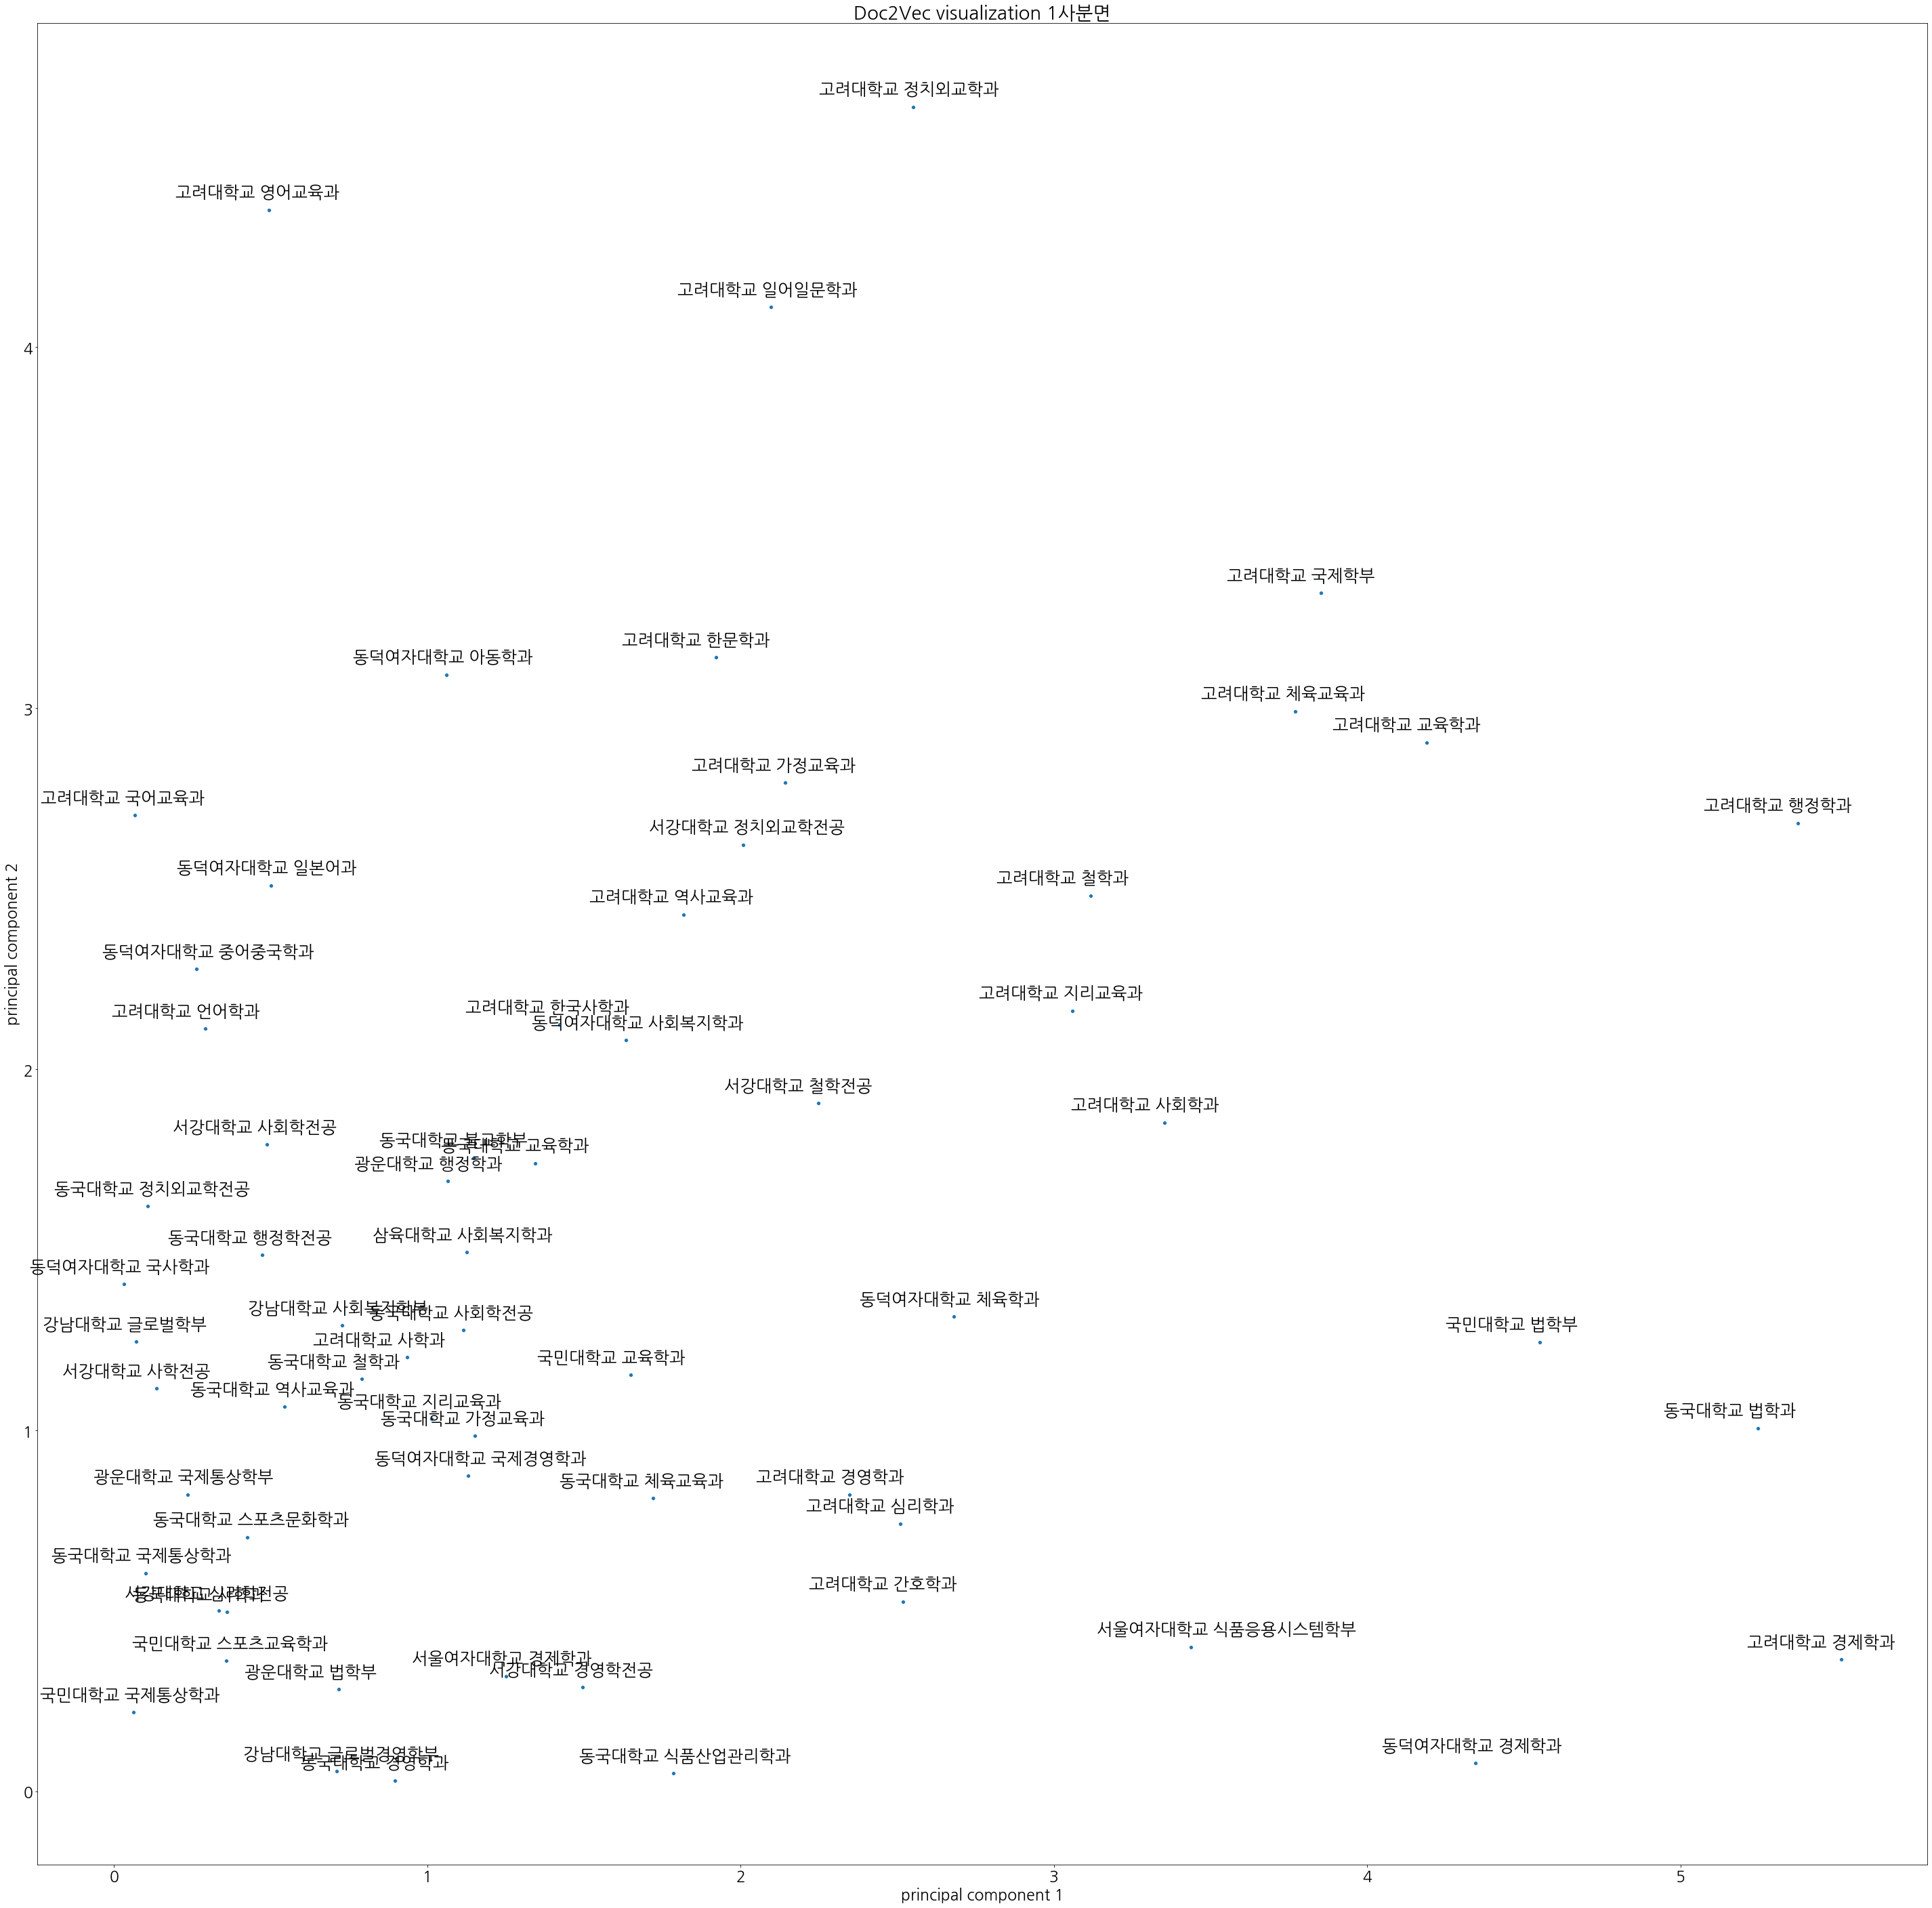

In [307]:
plt.figure(figsize=(50, 50))
ax=sns.scatterplot(x='principal component 1',y='principal component 2',data=df_1 ) 
plt.title('Doc2Vec visualization 1사분면')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 25
for i in range(len(df_1)):
    ax.text(float(df_1['principal component 1'][i]) - 0.3, float(df_1['principal component 2'][i]) + 0.035, df_1.index[i])




### 2사분면

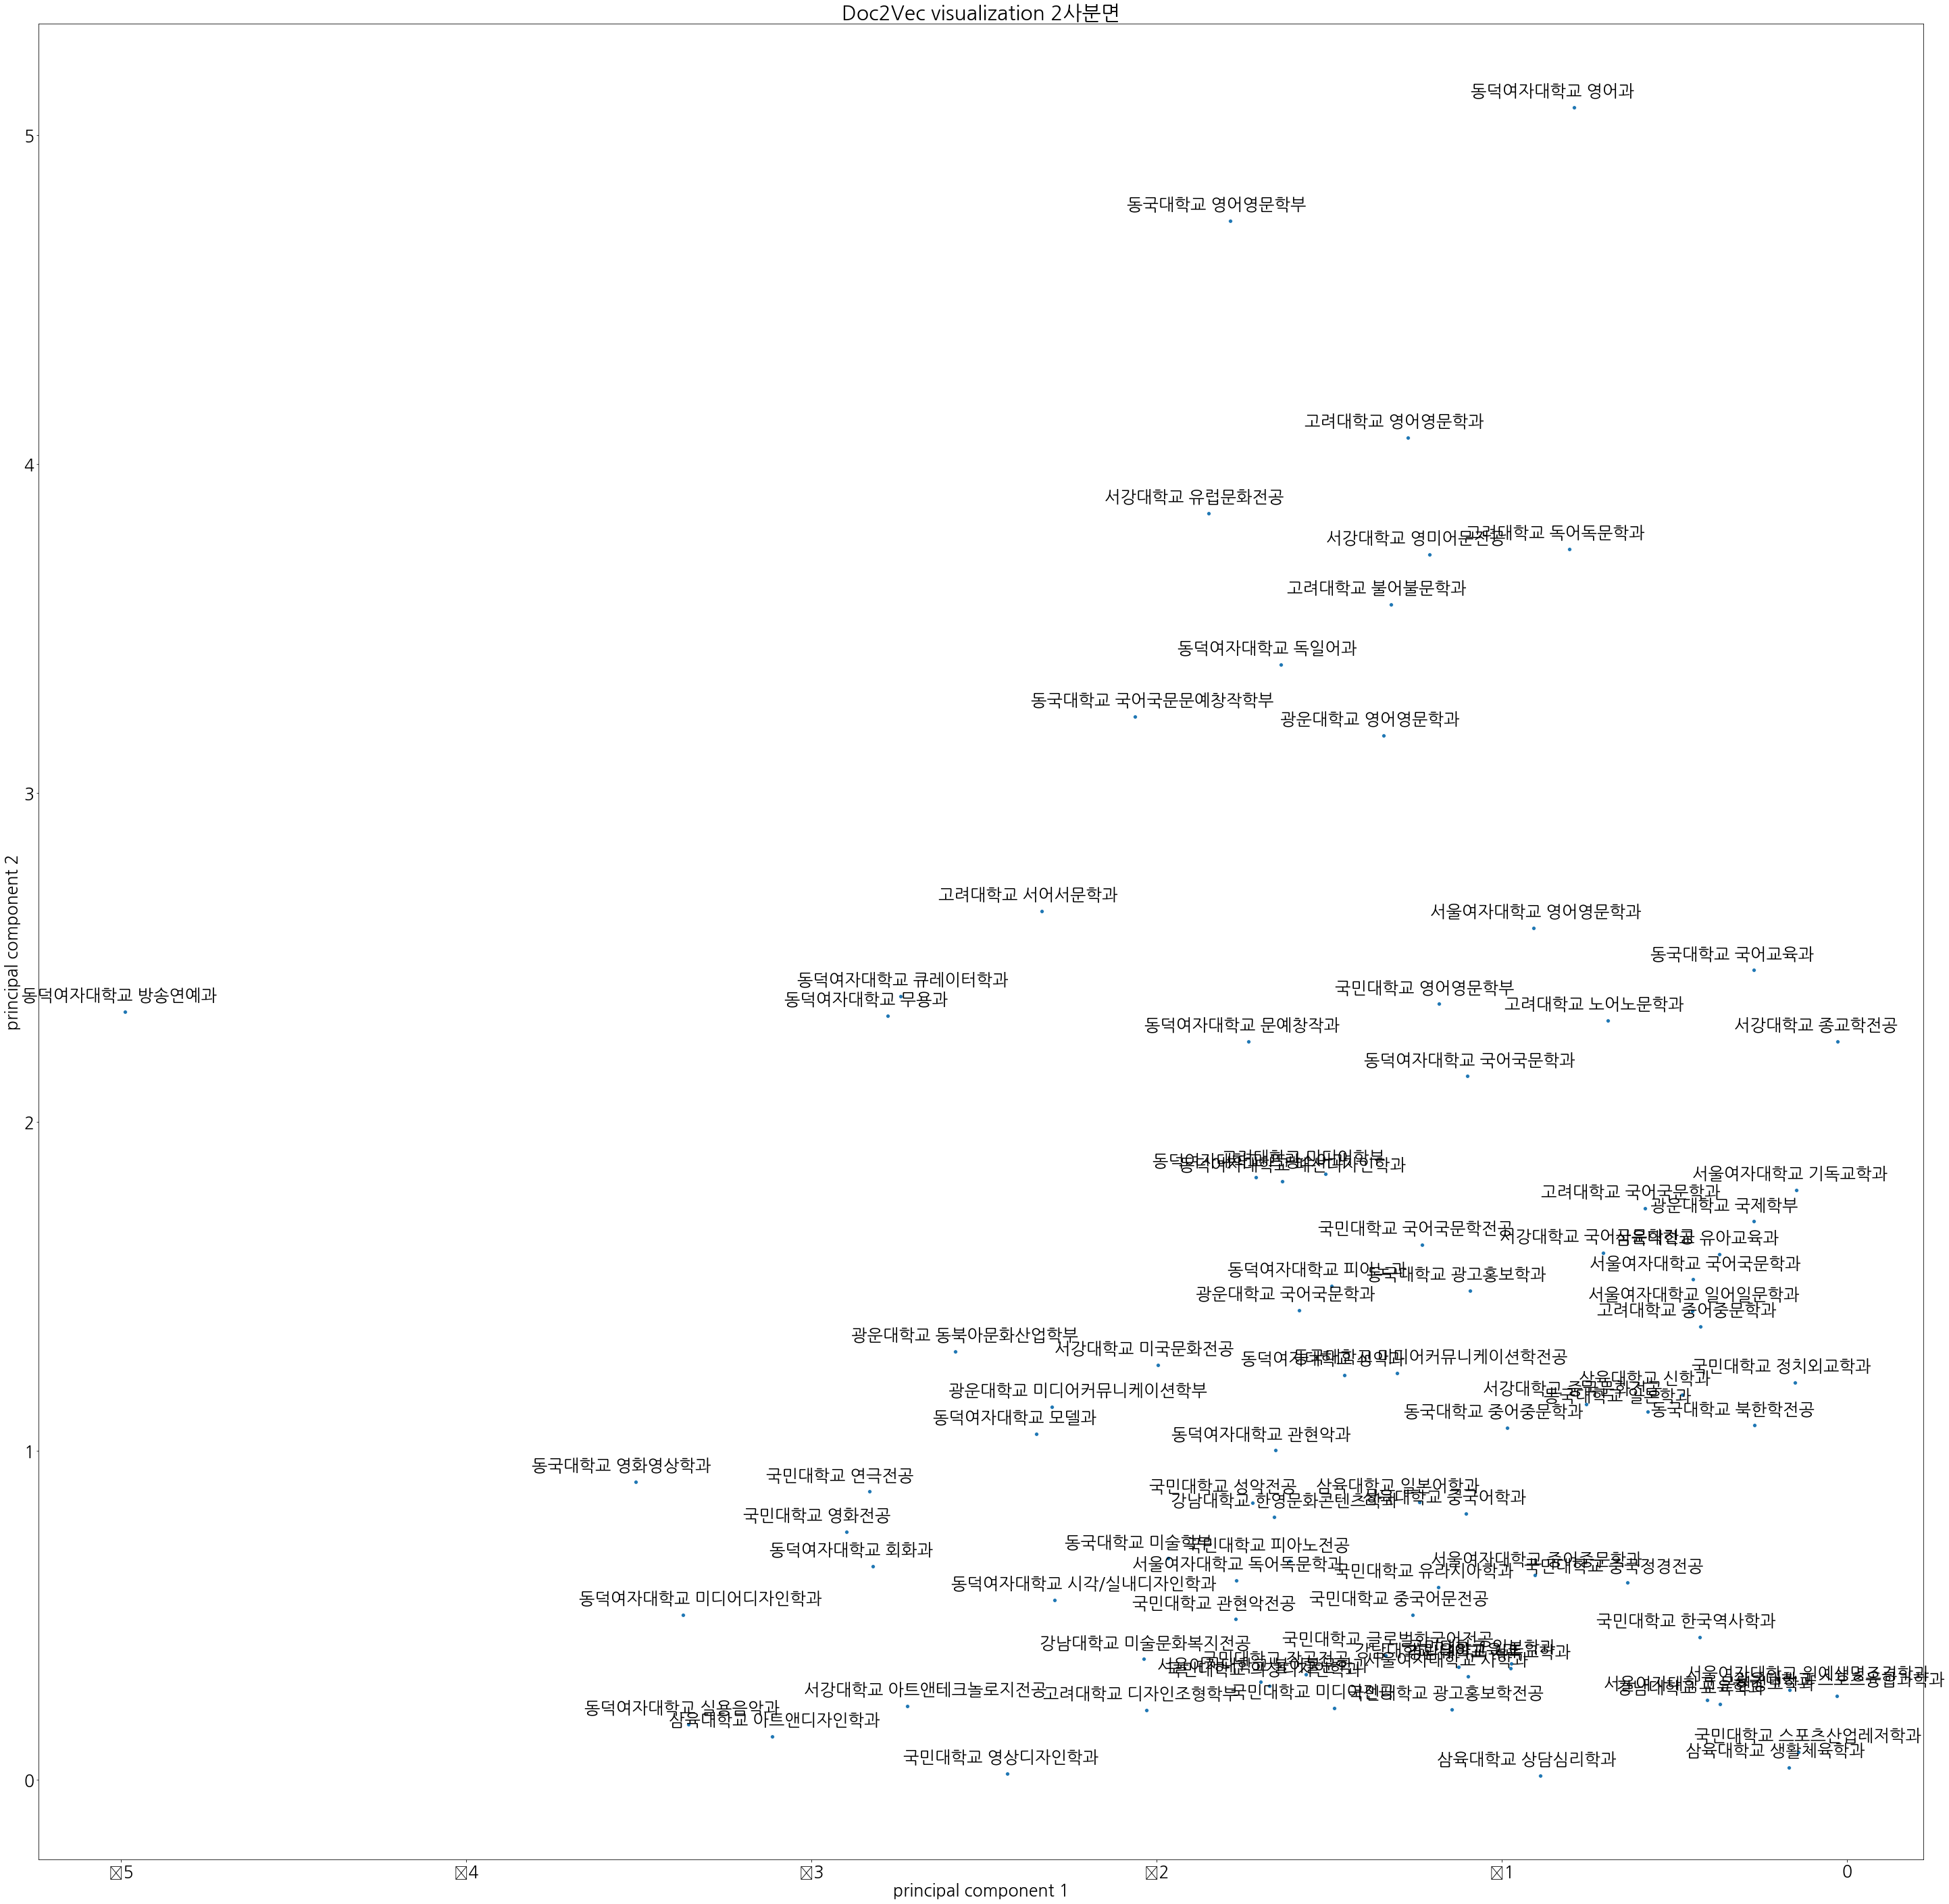

In [308]:
plt.figure(figsize=(50, 50))
ax=sns.scatterplot(x='principal component 1',y='principal component 2',data=df_2 ) 
plt.title('Doc2Vec visualization 2사분면')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 25
for i in range(len(df_2)):
    ax.text(float(df_2['principal component 1'][i]) - 0.3, float(df_2['principal component 2'][i]) + 0.035, df_2.index[i])

### 3사분면

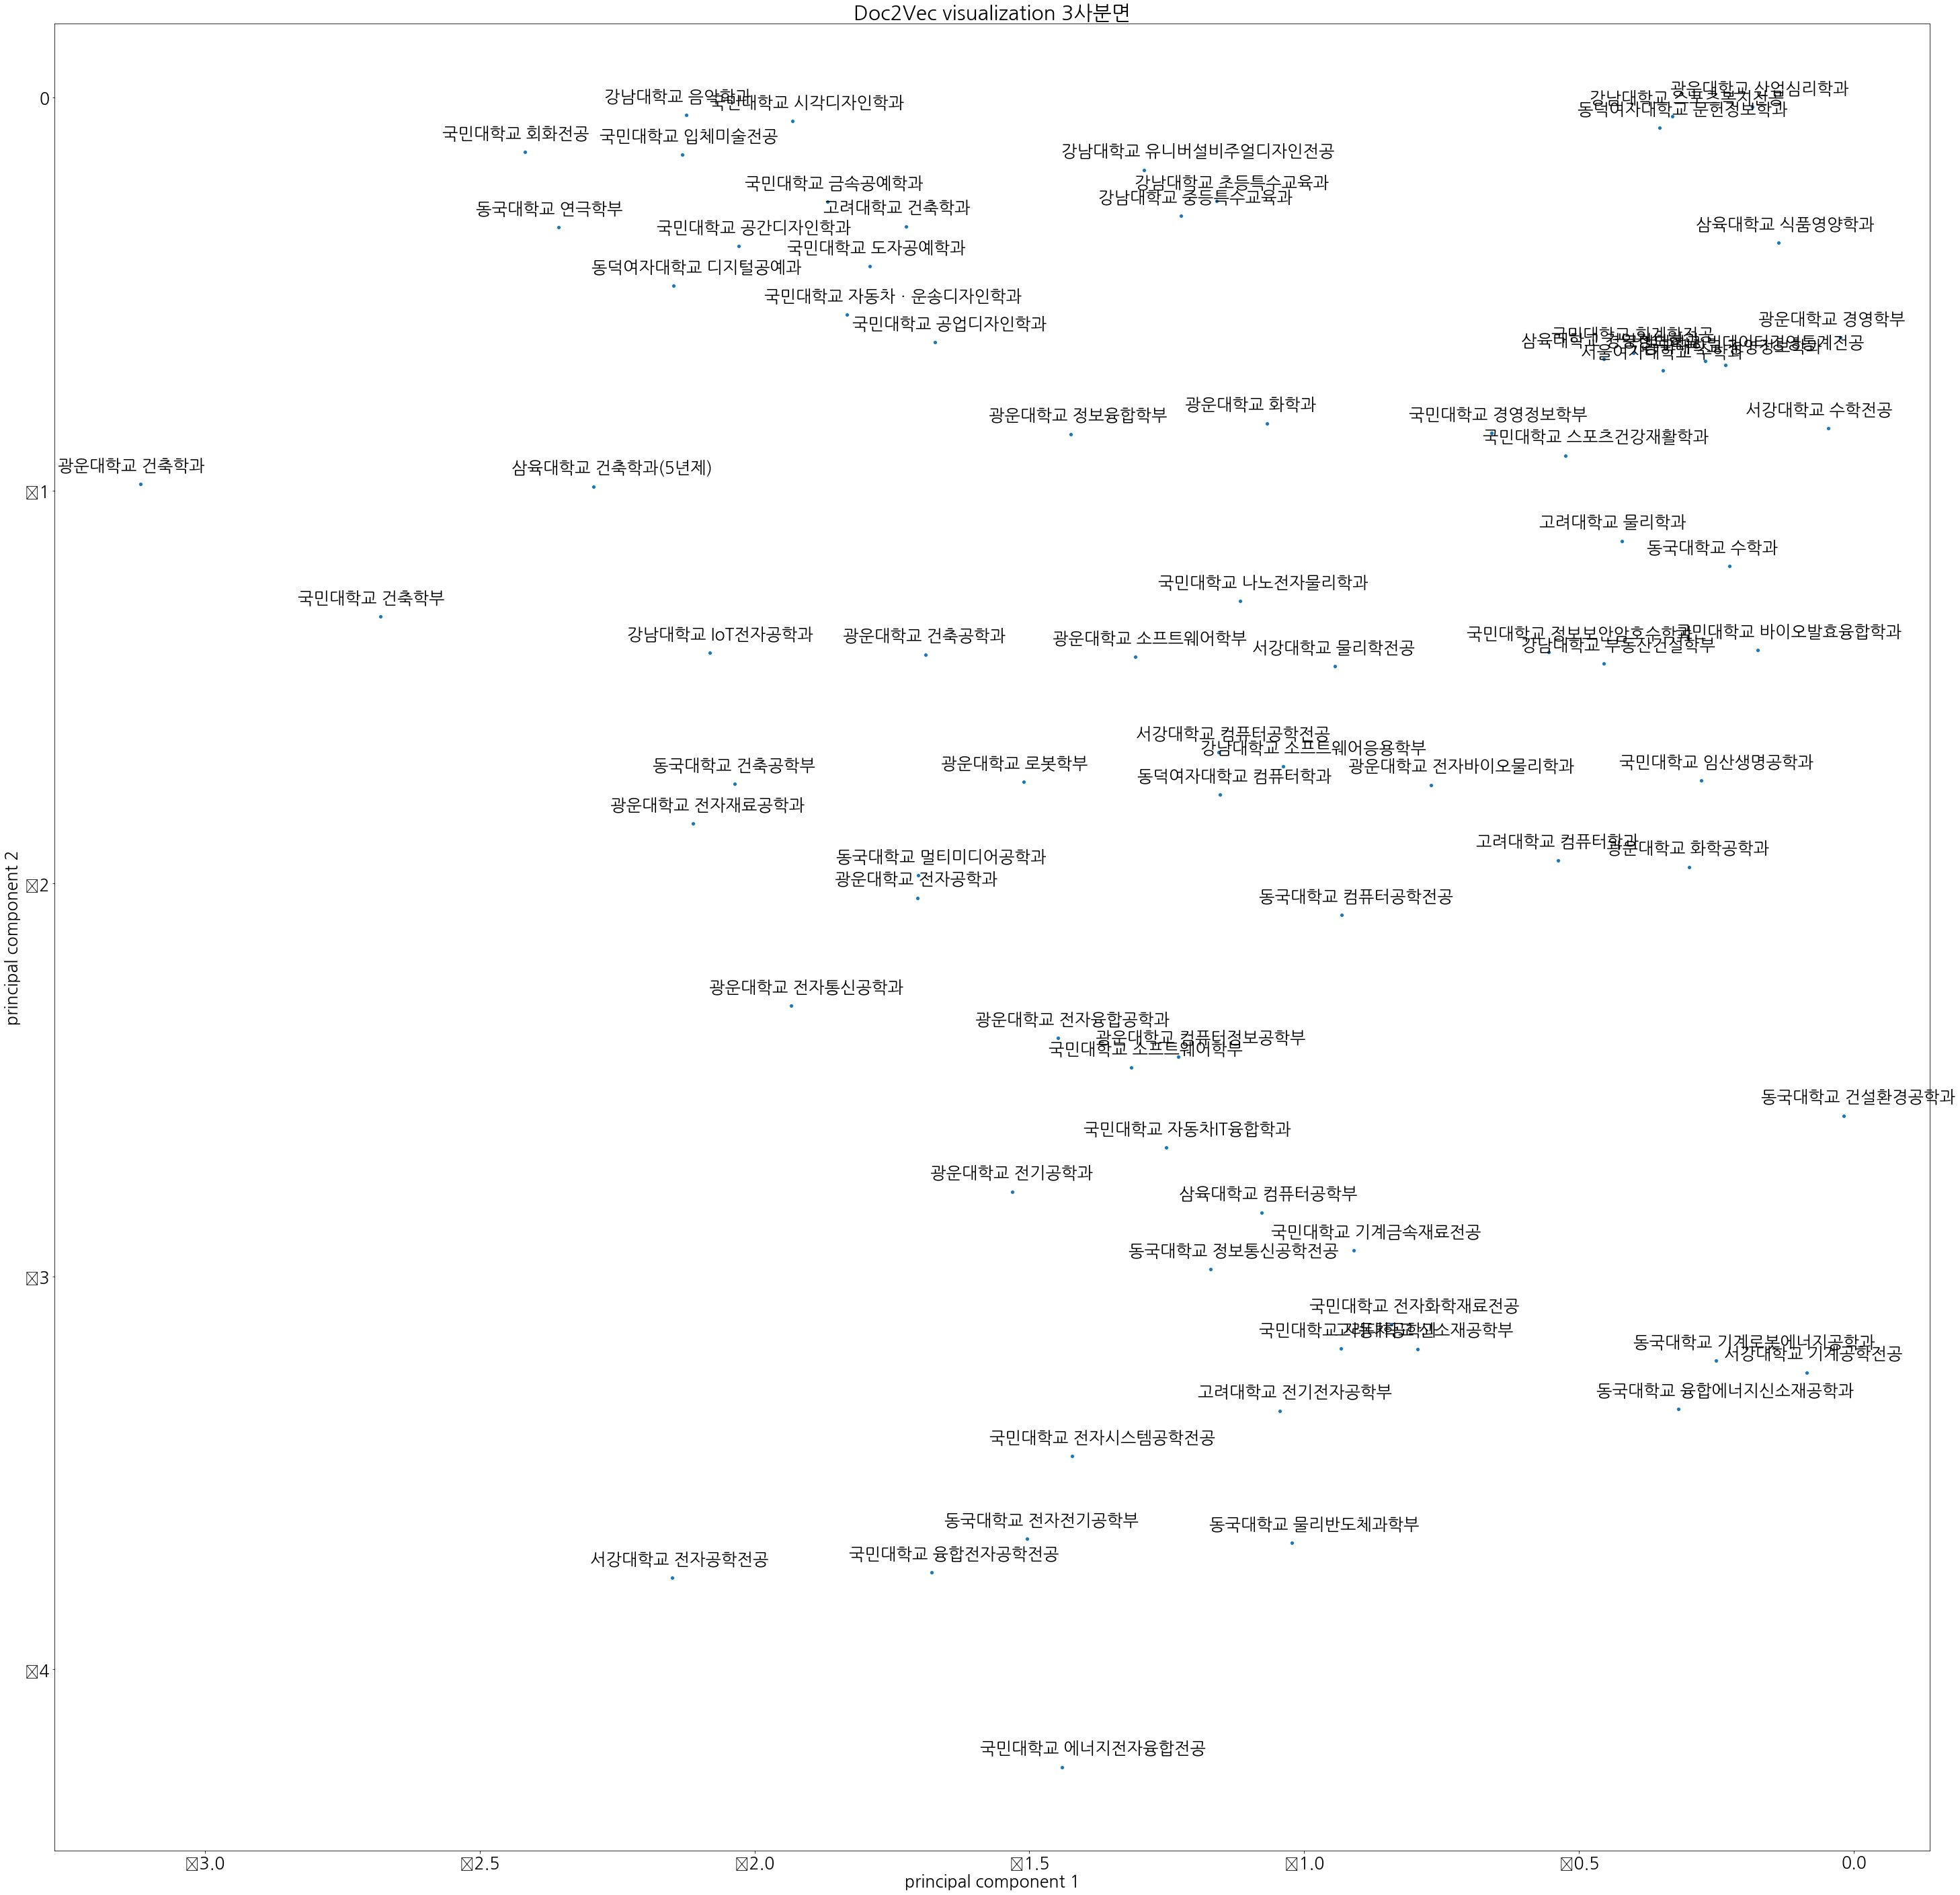

In [310]:
plt.figure(figsize=(50, 50))
ax=sns.scatterplot(x='principal component 1',y='principal component 2',data=df_3 ) 
plt.title('Doc2Vec visualization 3사분면')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 25
for i in range(len(df_3)):
    ax.text(float(df_3['principal component 1'][i]) - 0.15, float(df_3['principal component 2'][i]) + 0.035, df_3.index[i])
    


### 4사분면

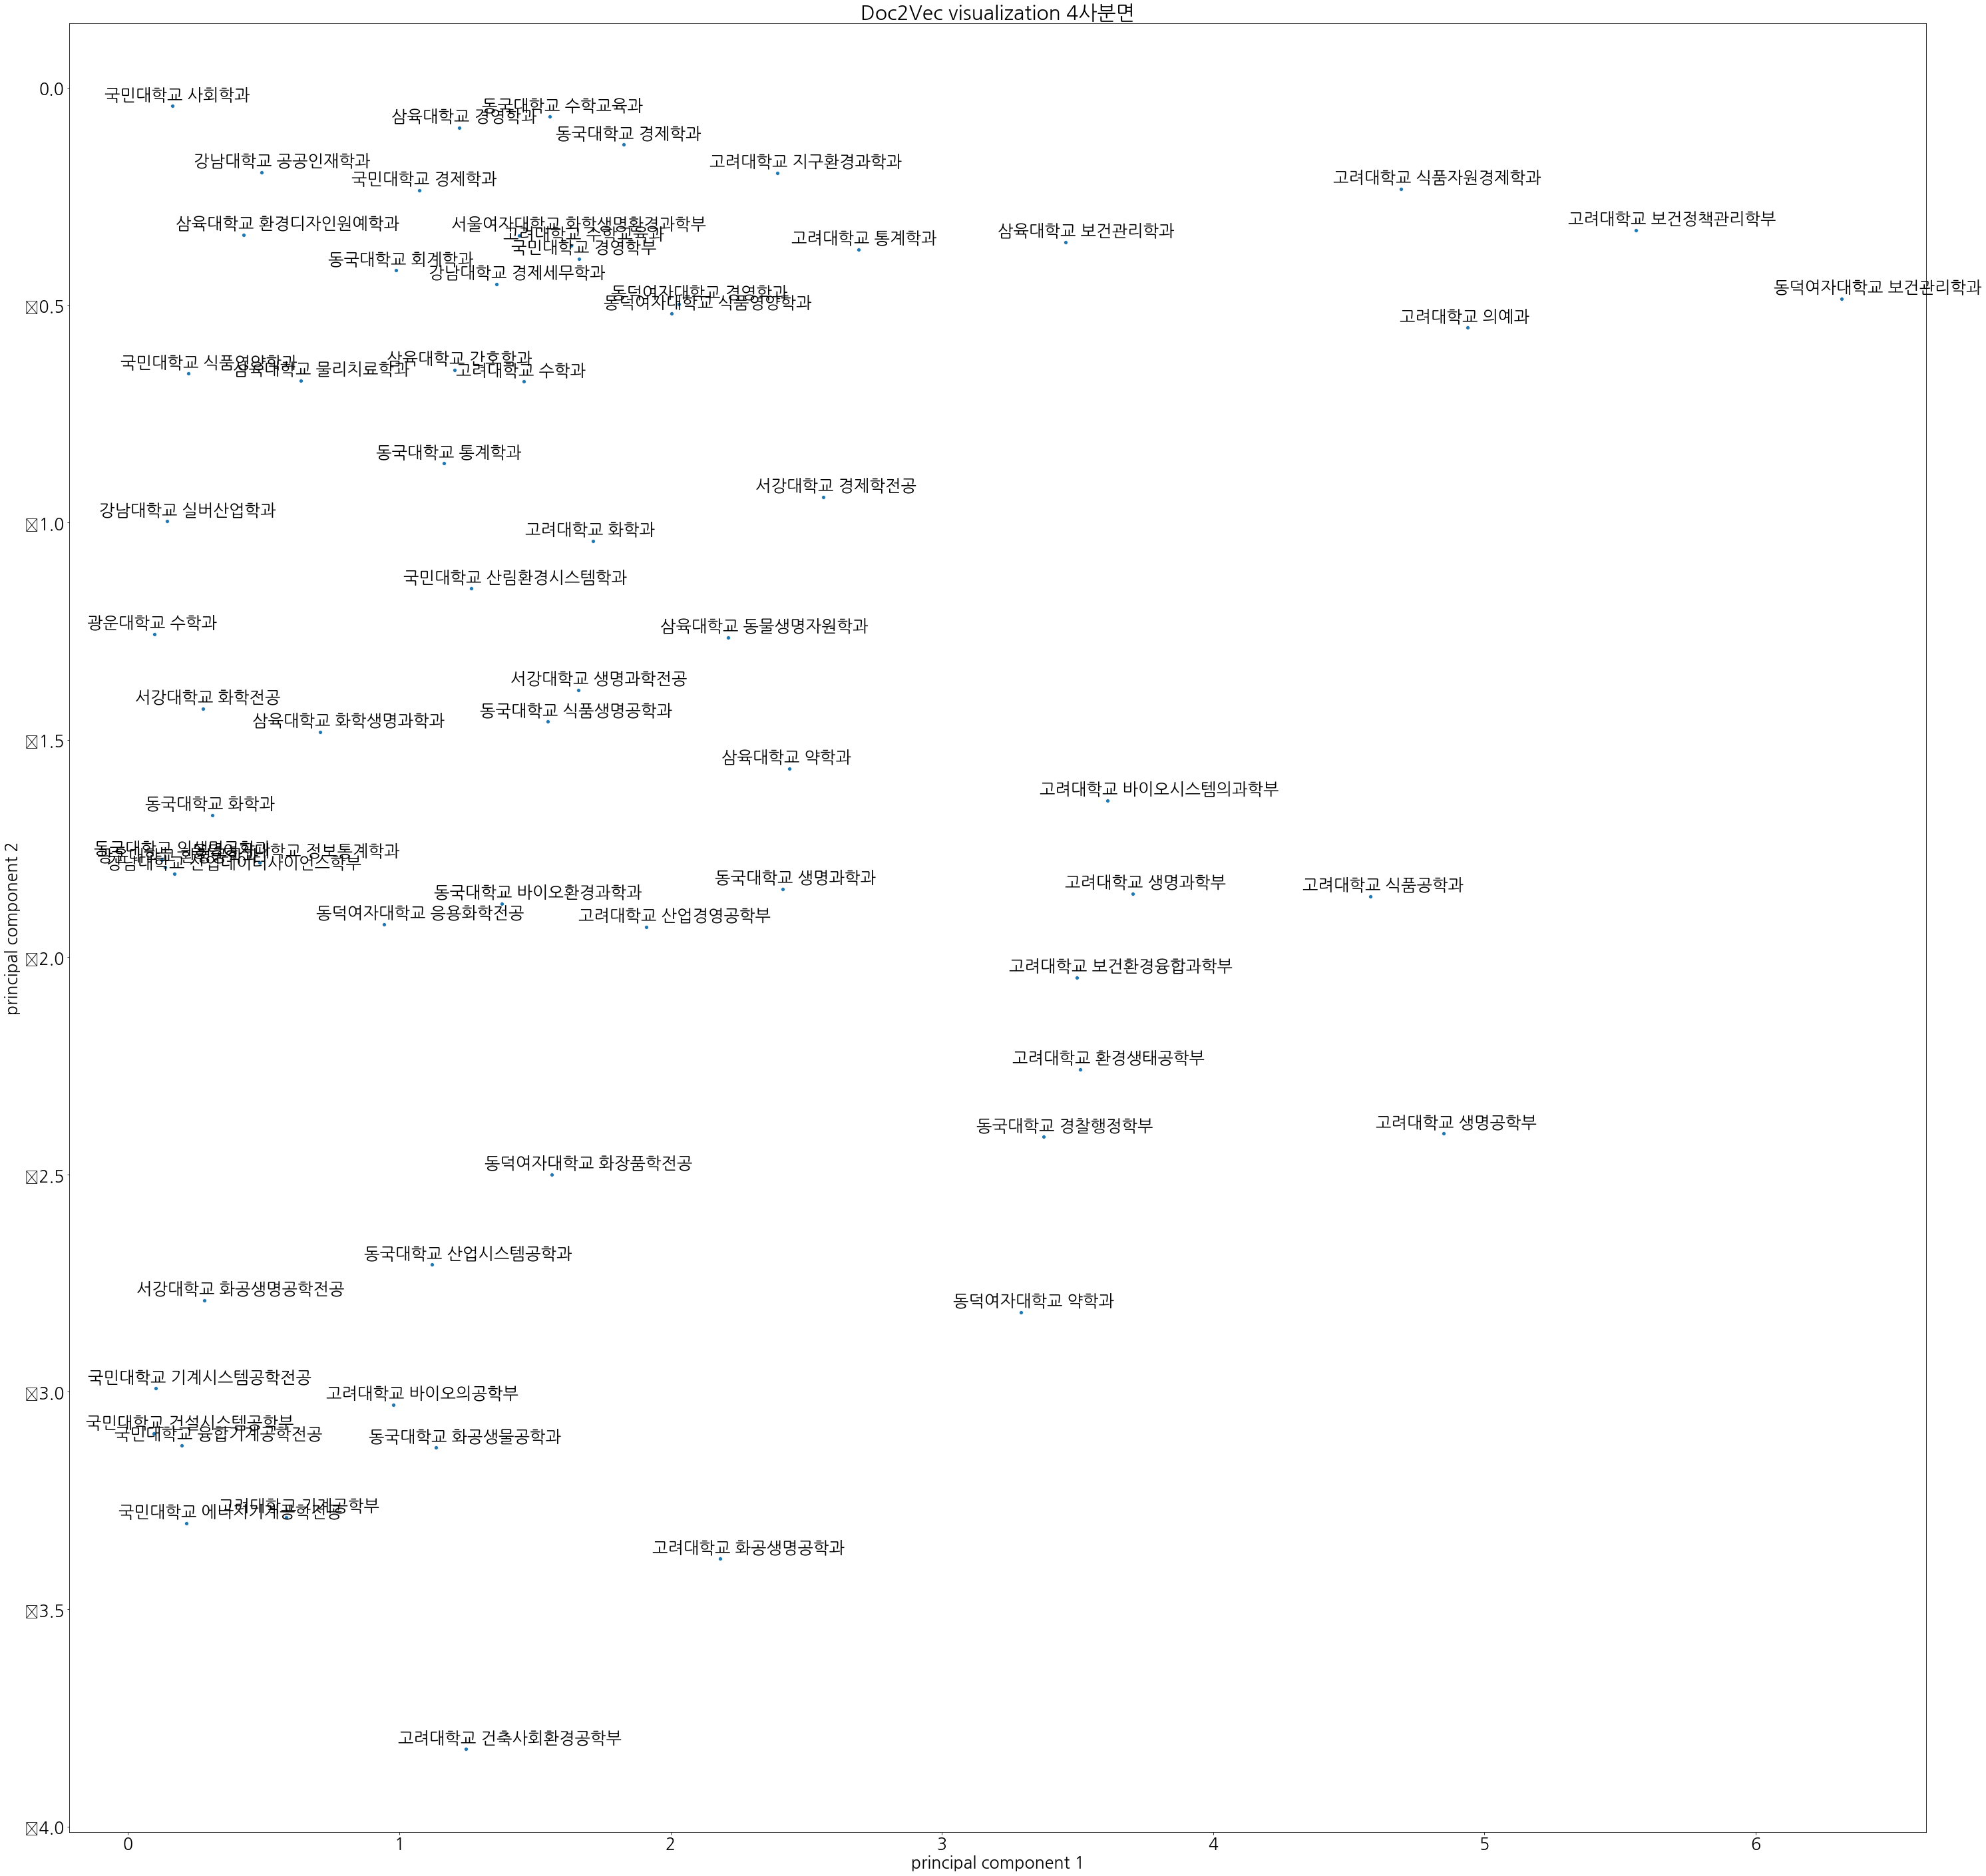

In [309]:
 
plt.figure(figsize=(50, 50))
ax=sns.scatterplot(x='principal component 1',y='principal component 2',data=df_4 ) 
plt.title('Doc2Vec visualization 4사분면')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 25
for i in range(len(df_4)):
    ax.text(float(df_4['principal component 1'][i]) - 0.25, float(df_4['principal component 2'][i]+0.015), df_4.index[i])
